# Final project: predicting activity from accelerometer data

## Introduction

we'll attempt to predict the type of physical activity (e.g., walking, climbing stairs) from tri-axial smartphone accelerometer data. Smartphone accelerometers are very precise, and different physical activities give rise to different patterns of acceleration.

###### Your goal is to classify different physical activities as accurately as possible

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook
import pandas as pd
import researchpy as rp
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

In [2]:
start=time.process_time() #Run Time

In [3]:
#first we need to import our files

train_time_series=pd.read_csv('train_time_series.csv',index_col=0)
test_time_series=pd.read_csv('test_time_series.csv',index_col=0)
train_labels=pd.read_csv('train_labels.csv',index_col=0)
test_labels=pd.read_csv('test_labels.csv',index_col=0)

### Cleaning train dataset

In [4]:
everytenth=range(20589,24330,10) #access only every 10th observation, the ones labeled
reduc_train_time=train_time_series.loc[everytenth]
remain_train_time=train_time_series.drop(index=everytenth)

reduc_train_time['label']=train_labels['label'] #merge the two datasets into one by creating one column for labels 

reduc_train_time 

,timestamp,UTC time,accuracy,x,y,z,label
20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985,1
20599,1565109932090,2019-08-06T16:45:32.090,unknown,0.013718,-0.852371,-0.000870,1
20609,1565109933092,2019-08-06T16:45:33.092,unknown,0.145584,-1.007843,-0.036819,1
20619,1565109934094,2019-08-06T16:45:34.094,unknown,-0.099380,-1.209686,0.304489,1
20629,1565109935097,2019-08-06T16:45:35.097,unknown,0.082794,-1.001434,-0.025375,1
...,...,...,...,...,...,...,...
24289,1565110302030,2019-08-06T16:51:42.030,unknown,-0.641953,-1.469177,0.301041,4
24299,1565110303032,2019-08-06T16:51:43.032,unknown,-0.171616,-0.366074,-0.059082,4
24309,1565110304034,2019-08-06T16:51:44.034,unknown,0.401810,-1.077698,0.258911,4
24319,1565110305037,2019-08-06T16:51:45.037,unknown,0.330338,-1.470062,0.303894,4


- x, y, and z correspond to measurements of linear acceleration along each of the three orthogonal axes and because the accelerometers are sampled at high frequency, the labels are only provided for every 10th observation
- labels correspond to different activities: 1 = standing, 2 = walking, 3 = stairs down, 4 = stairs up

In [5]:
# just to make sure there are no missing values
True in reduc_train_time.isna().values

False

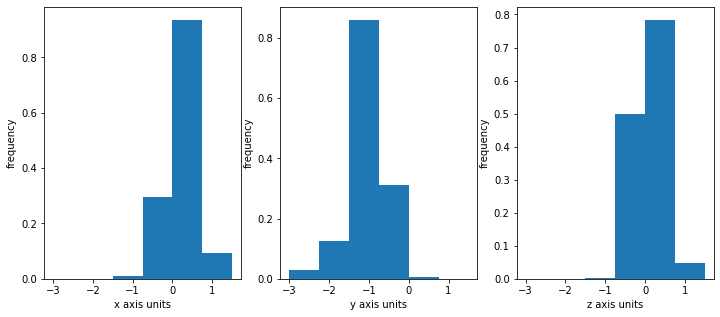

In [6]:
#visual inspection of common punctuations in x,y and z variables in general
plt.figure(figsize=(12,5))
for position,covar in [(131,'x'),(132,'y'),(133,'z')]:
    plt.subplot(position)
    plt.hist(reduc_train_time[covar],density=True,bins=np.linspace(-3,1.5,7)) #density->I want the proportion of observations that fall in each bin
    plt.xlabel(covar+' axis units')
    plt.ylabel('frequency')

In [7]:
#I want to examine the date more closely, so first I filt the data by label, and  I only take the x,y,z predictors

standing=reduc_train_time[reduc_train_time['label']==1]
walking=reduc_train_time[reduc_train_time['label']==2]
stairsdown=reduc_train_time[reduc_train_time['label']==3]
stairsup=reduc_train_time[reduc_train_time['label']==4]

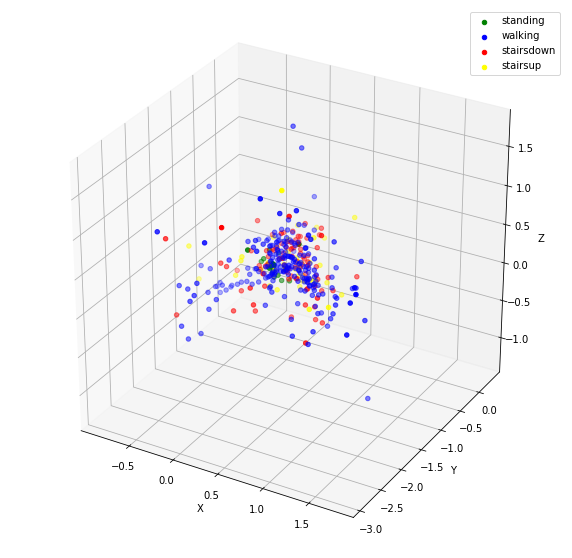

In [8]:
#3d plot with the xyz covariables
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(standing['x'],standing['y'],standing['z'],c='green',label='standing')
ax.scatter(walking['x'],walking['y'],walking['z'],c='blue',label='walking')
ax.scatter(stairsdown['x'],stairsdown['y'],stairsdown['z'],c='red',label='stairsdown')
ax.scatter(stairsup['x'],stairsup['y'],stairsup['z'],c='yellow',label='stairsup')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

I can see there some outliers that correspond to 'walking',but visual inspection is not very useful at this point, there are too many points together

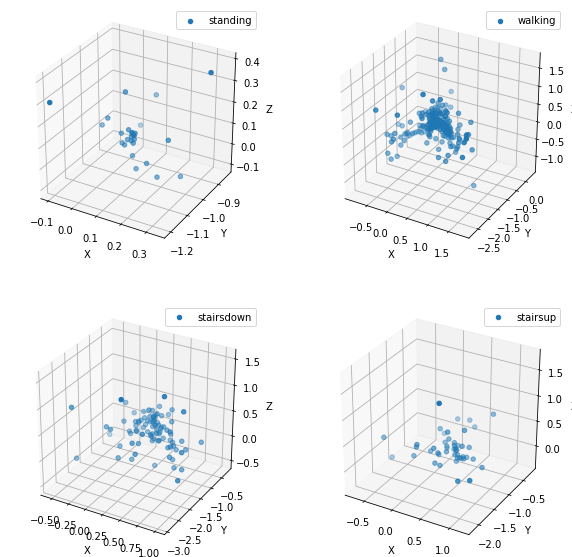

In [9]:
# 3d subplots displaying the same information as before but divided by label, in order to be easier to interpret
fig = plt.figure(figsize=(10,10))

def subplot(df,label,position):
    ax = fig.add_subplot(position,projection='3d')
    ax.scatter(df['x'],df['y'],df['z'],label=label)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(loc='upper right')
    
subplot(standing,'standing',221)
subplot(walking,'walking',222)
subplot(stairsdown,'stairsdown',223)
subplot(stairsup,'stairsup',224)

We have few 'standing' observations, that outcome is underrepresented and it could be a problem. In contrast, we have a lot of points that correspond to 'walking'. I cannot see clear patterns. However, I will check those statements now

In [10]:
# after visualizing the data I'd like to complement the exploratory analysis using statistics

print('general info: ',reduc_train_time.describe(),'\n')
print(rp.summary_cat(reduc_train_time['label'])) #summary stats for categorical variables (labels)
print('----'*18)
for df in [standing,walking,stairsdown,stairsup]:
    print(rp.summary_cont(df[['x','y','z']])) #summary stats for continuous variables (xyz timestamp)

general info:            timestamp           x           y           z       label
count  3.750000e+02  375.000000  375.000000  375.000000  375.000000
mean   1.565110e+12    0.214254   -1.009747    0.092230    2.413333
std    1.086802e+05    0.391877    0.457594    0.352037    0.799287
min    1.565110e+12   -0.863419   -2.919434   -1.248840    1.000000
25%    1.565110e+12    0.014862   -1.152794   -0.061554    2.000000
50%    1.565110e+12    0.203979   -0.954330    0.058731    2.000000
75%    1.565110e+12    0.428375   -0.769676    0.216187    3.000000
max    1.565110e+12    1.785187    0.321747    1.741806    4.000000 

  Variable  Outcome  Count  Percent
0    label        2    213    56.80
1                 3     88    23.47
2                 4     47    12.53
3                 1     27     7.20
------------------------------------------------------------------------


  Variable     N      Mean        SD        SE  95% Conf.  Interval
0        x  27.0  0.083710  0.088098  0.016954  

As expected, there are not many observations of 'standing' (N=27), and a lot of 'walking' (N=213)

In [11]:
# I don't know If the date gives any useful information
# But I'll transform them, just in case in need them later

reduc_train_time['UTC time']=pd.to_datetime(reduc_train_time['UTC time'],utc=True)
reduc_train_time['UTC time'].head()

20589   2019-08-06 16:45:31.087000+00:00
20599   2019-08-06 16:45:32.090000+00:00
20609   2019-08-06 16:45:33.092000+00:00
20619   2019-08-06 16:45:34.094000+00:00
20629   2019-08-06 16:45:35.097000+00:00
Name: UTC time, dtype: datetime64[ns, UTC]

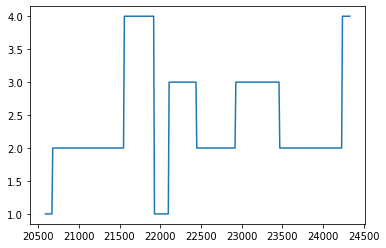

In [12]:
# what's the pattern of activity?

times=reduc_train_time['UTC time']
elapsed_time=[time-times[20589] for time in times]
ind=reduc_train_time.index
lab=reduc_train_time['label']
plt.plot(ind,lab);

### Cleaning test data

In [13]:
## I select the labeled observations from test_time_series As I did with the train data

everytenth=range(24339,25589,10) # access only every 10th observation, the ones labeled
reduc_test_time=test_time_series.loc[everytenth]
remain_test_time=test_time_series.drop(index=everytenth)

reduc_test_time['label']=test_labels['label'] # merge the two datasets into one by creating one column for labels 
reduc_test_time

,timestamp,UTC time,accuracy,x,y,z,label
24339,1565110307041,2019-08-06T16:51:47.041,unknown,0.098282,-0.833771,0.118042,NaN
24349,1565110308043,2019-08-06T16:51:48.043,unknown,0.348465,-0.946701,-0.051041,NaN
24359,1565110309046,2019-08-06T16:51:49.046,unknown,0.377335,-0.849243,-0.026474,NaN
24369,1565110310048,2019-08-06T16:51:50.048,unknown,0.110077,-0.520325,0.312714,NaN
24379,1565110311050,2019-08-06T16:51:51.050,unknown,0.283478,-0.892548,-0.085876,NaN
...,...,...,...,...,...,...,...
25539,1565110427366,2019-08-06T16:53:47.366,unknown,-0.043915,-0.242416,0.068802,NaN
25549,1565110428369,2019-08-06T16:53:48.369,unknown,0.118271,-1.212097,0.357468,NaN
25559,1565110429371,2019-08-06T16:53:49.371,unknown,0.667404,-0.978851,0.171906,NaN
25569,1565110430373,2019-08-06T16:53:50.373,unknown,0.371384,-1.021927,-0.244446,NaN


### Trying different models
In their review, (Farrahi et al, 2019) comment that there is not a clear superior technique for this kind of accelerometer data analysis. Because of that, I tried several strategies and I chose the one that seemed to be the best https://www.sciencedirect.com/science/article/pii/S0966636218313092

In [14]:
# Before fitting and testing the model with the given data, I want to experiment with the train data

# This is the data I'm going to use for the different models

X=np.array(reduc_train_time[['x','y','z']])
y=np.array(reduc_train_time['label'])
test=np.array(reduc_test_time[['x','y','z']])

In [15]:
# Logistic regression

X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.5) # split the data

logmodel=LogisticRegression()
logmodel.fit(X_train,y_train) # fit the model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
# now let's see how well it performs in terms of accuracy
print(logmodel.score(X_test,y_test))

0.5797872340425532


In [17]:
print(classification_report(y_test,logmodel.predict(X_test),zero_division=0))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        16
           2       0.58      1.00      0.73       109
           3       0.00      0.00      0.00        40
           4       0.00      0.00      0.00        23

    accuracy                           0.58       188
   macro avg       0.14      0.25      0.18       188
weighted avg       0.34      0.58      0.43       188



In [18]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.5)

forestmodel=RandomForestClassifier()
forestmodel.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [19]:
print(forestmodel.score(X_test,y_test))

0.5531914893617021


In [20]:
print(classification_report(y_test,forestmodel.predict(X_test)))

              precision    recall  f1-score   support

           1       0.33      0.43      0.38         7
           2       0.66      0.74      0.70       113
           3       0.38      0.30      0.33        44
           4       0.24      0.17      0.20        24

    accuracy                           0.55       188
   macro avg       0.40      0.41      0.40       188
weighted avg       0.53      0.55      0.54       188



In [21]:
# Knn

X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.5)

knnmodel=KNeighborsClassifier(n_neighbors=5)
knnmodel.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [22]:
knnmodel.score(X_test,y_test)

0.5904255319148937

In [23]:
print(classification_report(y_test,knnmodel.predict(X_test)))

              precision    recall  f1-score   support

           1       0.71      0.67      0.69        15
           2       0.60      0.91      0.72       101
           3       0.47      0.17      0.25        48
           4       0.33      0.04      0.07        24

    accuracy                           0.59       188
   macro avg       0.53      0.45      0.43       188
weighted avg       0.54      0.59      0.51       188



In [24]:
# I'm not sure which one to choose, so I'm going to run the process of fitting the model several times

logistic=[]
forest=[]
knn=[]
for iter in range(10):
    X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.5)
    logistic.append(np.mean(cross_val_score(logmodel ,X_test,y_test)))
    forest.append(np.mean(cross_val_score(forestmodel ,X_test,y_test)))
    knn.append(np.mean(cross_val_score(knnmodel,X_test,y_test)))

In [25]:
print('mean score logistic ',np.mean(logistic))
print('mean score forest ',np.mean(forest))
print('mean score knn ',np.mean(knn))

mean score logistic  0.5447795163584637
mean score forest  0.555732574679943
mean score knn  0.5754054054054054


In [26]:
# Looks like the knn method is slightly better than random forest, although the difference isn't statistically significant 
stats.ttest_ind(knn,forest, equal_var = False)

Ttest_indResult(statistic=1.1457154137930194, pvalue=0.2669187401912299)

In [27]:
X_train=np.array(reduc_train_time[['x','y','z']])
y_train=np.array(reduc_train_time['label'])
test=np.array(reduc_test_time[['x','y','z']])

final_model=KNeighborsClassifier(n_neighbors=5)
final_model.fit(X_train,y_train)

final_model.predict(test)

array([2, 2, 2, 3, 3, 2, 3, 3, 2, 2, 3, 3, 1, 2, 2, 1, 2, 3, 2, 2, 2, 3,
       2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 3, 2, 2, 1, 2, 2, 3, 2,
       3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 4, 2, 2, 2, 2, 3, 3, 3, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 1, 2, 2,
       3, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [28]:
label_predictions=final_model.predict(test)
test_labels['label']=label_predictions
test_labels.to_csv('test labels.csv')

In [29]:
end=time.process_time()
total=end-start
print(total,'seconds')

8.21875 seconds


### Summary

I haven't really understood the dataset. I've tried various approaches but I don't think I got anything useful. I wish I could say something relevant about this project, but I lack a lot of data analytic skills.Next time I'll do better